# Problème V : Analyse d’une série temporelle

#Taha EZ-ZOURY
#Marouane El Bissouri
#Youness Bouallou

Dans la suite on se base sur le modèle LSTM (long terme memory) qui opère d'une manière récurrente sur la base de donnée temporelle pour prédire le future.

In [328]:
#il s'agit d'une base de données mensuelle
data = pd.read_csv('Danube ammonium level Time Series.csv', sep = ';',decimal=',')
data["Months"]=pd.to_datetime(data["Months"], dayfirst = True)
data

,Months,Ammonium
0,1996-01-01,0.253333
1,1996-02-01,0.218889
2,1996-03-01,0.242000
3,1996-04-01,0.134545
4,1996-05-01,0.113333
...,...,...
259,2017-08-01,0.031222
260,2017-09-01,0.045875
261,2017-10-01,0.032474
262,2017-11-01,0.047125


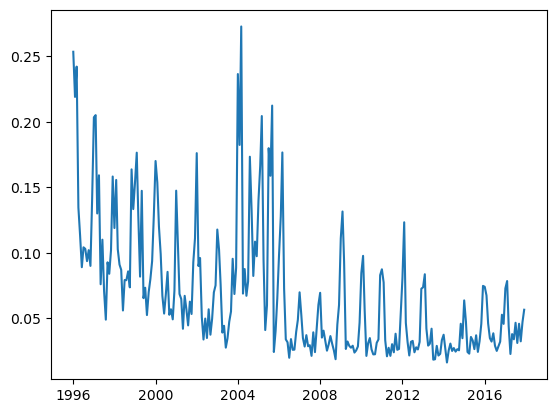

In [186]:
plt.plot(data["Months"], data["Ammonium"])

Normalisons la colonne "Ammonium" pas de façon que les les données soient standardisés mais qu'il soient compris entre 0 et 1 .

In [294]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x= np.array(data["Ammonium"]).reshape(-1, 1)
y = np.array(x[1:][:])
x=np.array(x[:263][:])
x_n = min_max_scaler.fit_transform(x)

On divise nos donnée tel que x représente le taux d'amonium à l'intant t et y à l'instant t+1.

Puisque LSTM prend une array tridimentionnel (batch size, sequence legth, number of features). On essaie de reshape nos données pour les accomoder à une telle structure, on procède avec une approche stochastique (batchsize=1).

In [295]:
x_n = np.reshape(x_n, (x_n.shape[0], 1, x_n.shape[1]))
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

Enfin, divisons nos données en test et train, tel que x présente les données au temps t et y en t+1.

In [298]:
split=data[data["Months"]=="2016-12-01"].index[0]
x_train, y_train= x_n[:split+1], y[:split+1]
x_test, y_test= x_n[split+1:], y[split+1:]

Créons le modèle, en choisissant des paramètres de notre choix.

Puisqu'on est interessé à l'output directment on utilisera la fonction linear dans le dernier layer, sigmoid est évitée car elle est plus adaptable à la classification binaire.

In [309]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
model = Sequential()
model.add(LSTM(200, activation='relu',input_shape=(x_train.shape[1],1)))
model.add(Dense(50))
model.add(Dense(1,activation="linear"))
model.compile(loss='mse', optimizer='Adam')
model.fit( x_train, y_train, epochs=100, batch_size=len(train)//10, verbose=0)

In [310]:
y_pred= model.predict(x_test, verbose=0)

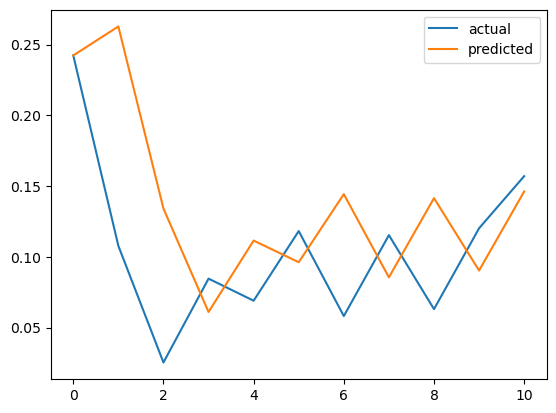

In [317]:
s=y_test.shape[0]
plt.plot(y_test.reshape((s,)), label="actual")
plt.plot(y_pred.reshape((s,)), label="predicted")
plt.legend()
plt.show()

In [314]:
score= model.evaluate(x_test, y_test, verbose=0)
print("rmse :", (score)**0.5)

rmse : 0.07019245974051425


Bien que les 2 courbes ont une monotonie opposée, on a achevé une bonne prédiction de nos données test.

## ARMA/ARIMA model

Il faut bien souligner la stationnarité d'une série pour qu'on lui applique ARIMA/ARMA càd que la moyenne et l'écart type restent constants pour chaque fenêtre prise de la série. 

In [329]:
#we set Months as index for adf test of stationarity
data.set_index('Months', inplace=True)

In [330]:
data.head()

,Ammonium
Months,
1996-01-01,0.253333
1996-02-01,0.218889
1996-03-01,0.242000
1996-04-01,0.134545
1996-05-01,0.113333


In [331]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print('Statistique ADF :', result[0])
print('Valeur critique :', result[4])
print('P-value :', result[1])

Statistique ADF : -1.9198289225041667
Valeur critique : {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
P-value : 0.3227912219065292


In [333]:
if result[1] < 0.05: #on prend l'erreur standard pour la p-valeur (5%)
    print("La série est stationnaire (rejeter l'hypothèse nulle)")
else:
    print("La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle)")

La série n'est pas stationnaire (ne pas rejeter l'hypothèse nulle)


On essaie de la differencier y_t= x_t - x_t-1, puis on mesure si elle est stationnaire.

In [334]:
data_diff= data.diff().dropna()

In [335]:
adfuller(data_diff)[1]

1.7660848633660758e-13

La série differenciée est bien stationnaire, essayons de la visualiser.

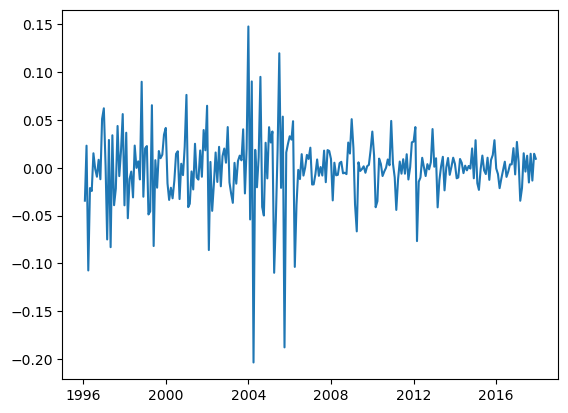

In [336]:
plt.plot(data_diff)

On essaie d'ajuster un modèle ARIMA sur la série differenciée.

In [352]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA 
train = data_diff.iloc[:split+1]
test = data_diff.iloc[split+1:]
model_arima = auto_arima(
    data_diff['Ammonium'],  
    suppress_warnings=True,          #suppress warnings generated 
    stationary=True,                  #treat time series as stationary
)

In [348]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  263
Model:               SARIMAX(4, 0, 3)   Log Likelihood                 542.702
Date:                Thu, 30 Nov 2023   AIC                          -1069.405
Time:                        20:19:24   BIC                          -1040.828
Sample:                    02-01-1996   HQIC                         -1057.920
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1621      0.091     12.717      0.000       0.983       1.341
ar.L2         -0.8852      0.093     -9.488      0.000      -1.068      -0.702
ar.L3          0.0524      0.083      0.634      0.526      -0.110       0.214
ar.L4          0.2113      0.065      3.269      0.001       0.085       0.338
ma.L1         -1.5466      0.082    -18.835      0.000      -1.708      -1.386
ma.L2          1.3728      0.104     13.214      0.000       1.169       1.576
ma.L3         -0.7532      0.071    -10.543      0.000      -0.893      -0.613
sigma2         0.0009   5.43e-05     17.338      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               237.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le modèle optimale est SARIMA(4,0,3).

C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\OH\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Months'>

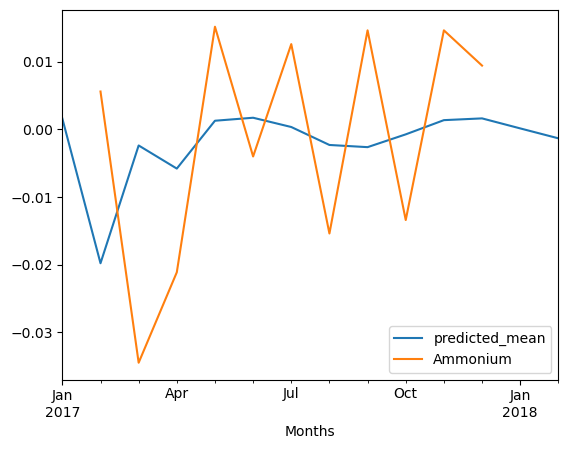

In [373]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_arima = SARIMAX(train["Ammonium"],order=(4,0,3))
fit = model_arima.fit()
pred = fit.predict(start = split, end = len(data), typ = 'levels')
pred.plot(legend = True)
test["Ammonium"].plot(legend = True)

In [381]:
np.sqrt(np.sum(((test["Ammonium"]-pred).dropna())**2))

0.056179965151220965

l'erreur obtenu est inférieure à celle obtenue avec LSTM.

Le modèle ARIMA a été plus performant.

## Modèle fine-tuned

On essaie de tuner nos hyperparamètres en utilisant l'optimisation bayesienne.

In [384]:
data = pd.read_csv('Danube ammonium level Time Series.csv', sep = ';',decimal=',')
data["Months"]=pd.to_datetime(data["Months"], dayfirst = True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [385]:
import sklearn
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
x= np.array(data["Ammonium"]).reshape(-1, 1)
y = np.array(x[1:][:])
x=np.array(x[:263][:])
x_n = min_max_scaler.fit_transform(x)
split=data[data["Months"]=="2016-12-01"].index[0]
x_train, y_train= x_n[:split+1], y[:split+1]
x_test, y_test= x_n[split+1:], y[split+1:]

In [386]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=500, step=50), 
                   activation='relu', input_shape=(x_train.shape[1], 1)))
    
    for i in range(hp.Int('num_layers', 1, 3)): 
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=10, max_value=100, step=10), 
                        activation='relu'))

    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,  
    executions_per_trial=2,  
    directory='my_dir',  
    project_name='lstm_hyperparam_tuning'
)

tuner.search(x_train, y_train, epochs=100, batch_size=len(train)//10, validation_split=0.2, verbose=0)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = tuner.hypermodel.build(best_hps)


In [387]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 500)               1004000   
                                                                 
 dense_4 (Dense)             (None, 50)                25050     
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1029571 (3.93 MB)
Trainable params: 1029571 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [388]:
history= best_model.fit(x_train, y_train, epochs=400, validation_split=0.2, verbose=0)

In [392]:
prec_par_epoch = history.history['val_loss']
epoch_opt = prec_par_epoch.index(min(prec_par_epoch)) 
print("meilleur epoch :", epoch_opt)

meilleur epoch : 31


In [393]:
model_best = tuner.hypermodel.build(best_hps)
model_best.fit(x_train, y_train, epochs=epoch_opt, validation_split=0.2,verbose=0)

In [394]:
y_pred = model_best.predict(x_test)

1/1 [==============================] - 0s 247ms/step


In [397]:
np.sqrt(np.sum((y_pred-y_test)**2))

0.06093491300777041

On a bien obtenu un mse inférieur au modèle initiale, mais l'ARIMA reste insurmontable.

# Conclusion :

- Notons que dans le dernier modèle, on a utlisé l'optimisateur bayesian à la place de grid search utlisé précédemment dans le modèle tuned en problème 4, en notant que cette méthode (bayesienne) effectue la recherche dans la grille des hyperparamètres d'une manière probabiliste. En résumé, Keras Tuner est une bibliothèque plus large qui offre différentes méthodes de recherche d'hyperparamètres, y compris l'optimisation bayésienne, tandis que l'optimisation bayésienne est une technique spécifique qui peut être utilisée pour optimiser les hyperparamètres de divers modèles d'apprentissage automatique. Utilisées ensemble, elles permettent d'effectuer une recherche d'hyperparamètres plus efficace pour les modèles Keras.4

- Il faut aussi ajouter qu'on a fine tune que le learning rate des optimisateurs, le nombre de couches intérmédiaires, et le nombre des unités par chaque couche. Pour aller au dessus, on peut aussi optimiser les $\beta_1$ et $\beta_2$ dans l'optimisateur Adam, et aussi le $\epsilon$ utilisé pour eviter les zeros dans le dénominateur, mais cela reste assez spécifique et demandera des CPUs et GPUs plus puissants.